# Simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

## Retrocausal model

For the amplifier Hamiltonian, the "retrocausal" diffusion microdynamics in Drummond and Reid's model is
$$
\begin{align*}
    q(t) &= q(t_f) - \int_{t}^{t_f} q(s)\mathrm{d}s + \sqrt{2}\int_t^{t_f}\mathrm{d}w_2.
\end{align*}
$$

Backward Euler-Maruyama for $q(t)$

In [2]:
def sim_retrocausal(q0, tf=4.0, m=1000, N=10, rng=0):
    rng = np.random.default_rng(rng)
    dt = tf / m
    q = np.zeros((N, m + 1))
    q[:, -1] = rng.normal(q0 * np.exp(tf), 1, N)

    for i in range(m - 1, -1, -1):
        dw2 = rng.normal(0, np.sqrt(dt), N)
        q[:, i] = q[:, i + 1] - q[:, i + 1] * dt + np.sqrt(2) * dw2

    return q

# Forward equivalent

Our forward equivalent microdynamics is
$$
\begin{align*}
    \mathrm{d}q &= \left(q+2\partial_q\log\mu_{t}(q)\right)\mathrm{d}t + \sqrt{2} \ \mathrm{d}\bar{w}_2\\
    &= \left(2q_0 e^{t} - q\right)\mathrm{d}t + \sqrt{2} \ \mathrm{d}\bar{w}_2.
\end{align*}
$$

In [3]:
def sim_forward(q0, tf=4.0, m=1000, N=10, rng=0):
    rng = np.random.default_rng(rng)
    dt = tf / m
    q = np.zeros((N, m + 1))
    q[:, 0] = rng.normal(q0, 1, N)

    for i in range(m):
        dw2 = rng.normal(0, np.sqrt(dt), N)
        t = i * dt
        q[:, i + 1] = q[:, i] + (2 * q0 * np.exp(t) - q[:, i]) * dt + np.sqrt(2) * dw2

    return q

## Mean-field

The approximating $N$-system with potential $V(q, x) = \frac{1}{2}(q-x)^2$ is
$$
\begin{align*}
    \mathrm{d}q_i &= \left(q_i-\frac{2}{N}\sum_{j=1}^N \partial_{q_i} V(q_i, q_j)\right)\mathrm{d}t + \sqrt{2} \ \mathrm{d}\bar{w}_2\\
    &= \left(2\bar{q} - q\right)\mathrm{d}t + \sqrt{2} \ \mathrm{d}\bar{w}_2, \quad i=1, \ldots, N,
\end{align*}
$$
where $\bar{q} = \frac{1}{N}\sum_{j=1}^N q_j$.

In [4]:
def sim_meanfield(q0, tf=4.0, m=1000, N=10, N_system=10, rng=0):
    rng = np.random.default_rng(rng)
    dt = tf / m
    q = np.zeros((N_system, N, m + 1))
    q[:, :, 0] = rng.normal(q0, 1, (N_system, N))

    for i in range(m):
        dw2 = rng.normal(0, np.sqrt(dt), (N_system, N))
        q_mean = np.mean(q[:, :, i], axis=0, keepdims=True)
        q[:, :, i + 1] = q[:, :, i] + (2 * q_mean - q[:, :, i]) * dt + np.sqrt(2) * dw2

    return q[0, :, :]

## Visually compare the three models

Simulation parameters

In [5]:
tf = 4.0
m = 1000
q0 = 1.0

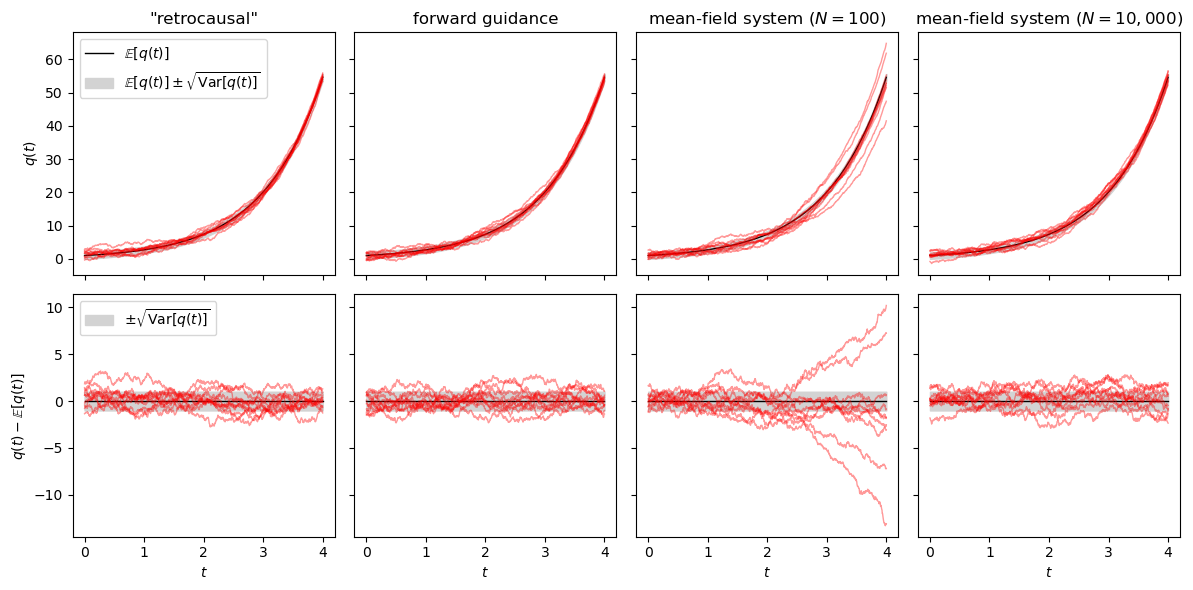

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey="row", sharex="col")

t_grid = np.linspace(0, tf, m + 1)

q_mean = q0 * np.exp(t_grid)

for ax in axes[0]:
    ax.plot(t_grid, q_mean, 'k-', linewidth=1, label='$\\mathbb{E}[q(t)]$')
    ax.fill_between(t_grid, q_mean - 1, q_mean + 1, color='lightgray', label='$\\mathbb{E}[q(t)]\\pm\\sqrt{\\mathrm{Var}[q(t)]}$')

axes[0, 0].legend(loc='upper left')

for ax in axes[1]:
    ax.plot(t_grid, np.zeros_like(t_grid), 'k-', linewidth=1)
    ax.fill_between(t_grid, -1, +1, color='lightgray', label='$\\pm\\sqrt{\\mathrm{Var}[q(t)]}$')

axes[1, 0].legend(loc='upper left')

N = 10
alpha = 4 / N

q = sim_retrocausal(q0, tf=tf, m=m, N=N, rng=rng)
axes[0, 0].plot(t_grid, q.T, 'r', linewidth=1, alpha=alpha)
axes[1, 0].plot(t_grid, (q - q_mean).T, 'r', linewidth=1, alpha=alpha)
q = sim_forward(q0, tf=tf, m=m, N=N, rng=rng)
axes[0, 1].plot(t_grid, q.T, 'r', linewidth=1, alpha=alpha)
axes[1, 1].plot(t_grid, (q - q_mean).T, 'r', linewidth=1, alpha=alpha)

N_system = 100
q = sim_meanfield(q0, tf=tf, m=m, N=N, N_system=N_system, rng=rng)
axes[0, 2].plot(t_grid, q.T, 'r', linewidth=1, alpha=alpha)
axes[1, 2].plot(t_grid, (q - q_mean).T, 'r', linewidth=1, alpha=alpha)
axes[0, 2].set_title(f"mean-field system ($N = {N_system:,}$)")

N_system = 10000
q = sim_meanfield(q0, tf=tf, m=m, N=N, N_system=N_system, rng=rng)
axes[0, 3].plot(t_grid, q.T, 'r', linewidth=1, alpha=alpha)
axes[1, 3].plot(t_grid, (q - q_mean).T, 'r', linewidth=1, alpha=alpha)
axes[0, 3].set_title(f"mean-field system ($N = {N_system:,}$)")

axes[0, 0].set_title('"retrocausal"')
axes[0, 1].set_title("forward guidance")

axes[1, 0].set_xlabel('$t$')
axes[1, 1].set_xlabel('$t$')
axes[1, 2].set_xlabel('$t$')
axes[1, 3].set_xlabel('$t$')

axes[0, 0].set_ylabel('$q(t)$')
axes[1, 0].set_ylabel('$q(t) - \\mathbb{E}[q(t)]$')

# axes[1, 0].set_ylim(-15, 15)

plt.tight_layout()
plt.savefig("simulations.pdf")
plt.savefig("simulations.png")
plt.show()